[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Returns
Date,,,,,,,
1999-01-06,125.812500,127.750000,125.750000,127.437500,80.356346,7737700,2.382273
1999-01-07,126.375000,127.218750,125.781250,126.812500,79.962265,5504900,-0.491623
2018-12-10,263.369995,265.160004,258.619995,264.070007,238.881027,151445900,0.189559
2018-12-11,267.660004,267.869995,262.480011,264.130005,238.935242,121504400,0.022693


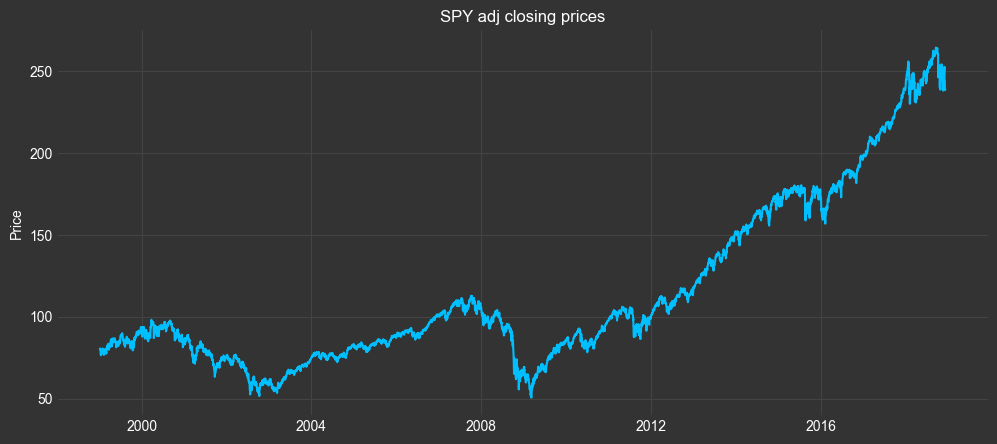

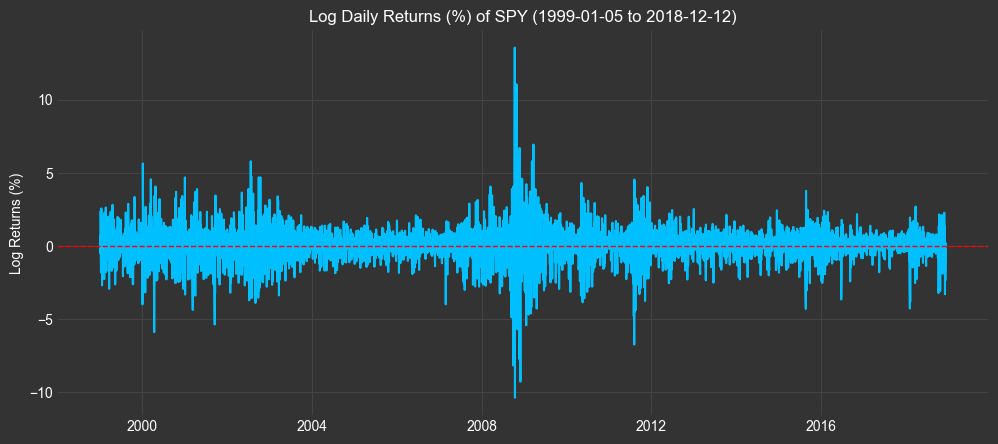

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = '#333333'
plt.rcParams['axes.facecolor'] = '#333333'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#444444'

# Download SPY price data from Yahoo Finance
start_date = "1999-01-05"
end_date = "2018-12-12"
ticker = "SPY"
spy_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log daily returns
spy_data['Log_Returns'] = 100 * np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1))

# Drop missing values (from the shift operation)
spy_data = spy_data.dropna()

### Plot Closing (adj) prices
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(spy_data['Adj Close'], color='deepskyblue')
ax.set(title='SPY adj closing prices', ylabel='Price')

# Preview first & last 2 rows
display(pd.concat([spy_data.head(2), spy_data.tail(2)]))

# Plot the log daily returns
plt.figure(figsize=(12,5))
plt.plot(spy_data.index, spy_data['Log_Returns'], label='Log Daily Returns (%)', color='deepskyblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Log Daily Returns (%) of SPY (1999-01-05 to 2018-12-12)")
plt.ylabel("Log Returns (%)")
plt.show()


### Shapiro-Wilk Normality test

In [2]:
from scipy import stats

stats.shapiro(spy_data['Log_Returns'])

statistic, p_value = stats.shapiro(spy_data['Log_Returns'])

# Print Shapiro-Wilk test results
print("W-test Statistic:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\nNormality absence.")
else:
    print("\nNormality presence.")

W-test Statistic: 0.9112411500875871
p-value: 2.7910792989279655e-47

Normality absence.


### Fat tails test

In [3]:
print("Mean:", round(np.mean(spy_data['Log_Returns']), 4))
print("Standard Deviation:", round(np.std(spy_data['Log_Returns']), 4))
print("Skewness:", round(stats.skew(spy_data['Log_Returns']), 4))
print("Kurtosis:", round(stats.kurtosis(spy_data['Log_Returns']), 4))

Mean: 0.0222
Standard Deviation: 1.2059
Skewness: -0.0661
Kurtosis: 10.1251


### KPSS Stationarity test

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss

# KPSS test
statistic, p_value, n_lags, critical_values = kpss(spy_data.Log_Returns, regression='c')

# Print KPSS results
print("KPSS Statistic:", statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

if p_value < 0.05:
    print("\nStationarity absence.")
else:
    print("\nStationarity presence.")

KPSS Statistic: 0.21939502708335637
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Stationarity presence.


C:\Users\konstantinos\AppData\Local\Temp\ipykernel_7880\2404549162.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(spy_data.Log_Returns, regression='c')


# GARCH

### Optimizing GARCH (parameters)

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
ps = range(0, 16, 1)
qs = range(0, 16, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7

In [7]:
# GARCH(p, q) with p<=2, q<=2 usually used??
ps = range(1, 10, 1)
qs = range(1, 10, 1)

order_list = list(product(ps, qs))
print(order_list)

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


## GARCH Optimization function

In [8]:
from arch import arch_model
import pandas as pd
from typing import Union, List, Tuple
from tqdm.notebook import tqdm_notebook
import numpy as np

def optimize_GARCH(endog: Union[pd.Series, list], order_list: List[Tuple[int, int]], volatility_model: List[str], distributions: List[str], mean_model: List[str]) -> pd.DataFrame:

    results = []
    for order in tqdm_notebook(order_list):
        for vol_mod in volatility_model:
            for distrib in distributions:
                for mean_mod in mean_model:
                    try:
                        model = arch_model(endog, p=order[0], q=order[1], mean=mean_mod, vol=vol_mod, dist=distrib)
                        
                        fitted = model.fit(disp='off', show_warning=False)
                        aic = fitted.aic
                        results.append([vol_mod, distrib, mean_mod, order, aic])

                    except Exception as e:
                        print(f"Failed for order {order}: {str(e)}")
                        continue
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['volatility_model', 'distribution', 'mean_model', '(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [9]:
mean_model = ['zero', 'constant']
volatility_model = ['GARCH', 'EGARCH']
distributions = ['normal', 'studentst', 'skewstudent']
result_df = optimize_GARCH(spy_data['Log_Returns'], order_list, volatility_model, distributions, mean_model)
result_df.head(10)

  0%|          | 0/81 [00:00<?, ?it/s]

,volatility_model,distribution,mean_model,"(p,q)",AIC
0,GARCH,skewstudent,constant,"(2, 2)",13551.548521
1,GARCH,skewstudent,constant,"(2, 1)",13552.114434
2,GARCH,skewstudent,constant,"(2, 3)",13553.179248
3,GARCH,skewstudent,constant,"(3, 2)",13553.548521
4,GARCH,skewstudent,constant,"(3, 1)",13554.114439
5,GARCH,skewstudent,constant,"(2, 4)",13554.614763
6,GARCH,skewstudent,constant,"(2, 5)",13554.946767
7,GARCH,skewstudent,constant,"(3, 3)",13555.179248
8,GARCH,skewstudent,constant,"(2, 6)",13555.346094
9,GARCH,skewstudent,constant,"(4, 2)",13555.548521


### Fitting best GARCH model on log returns

In [10]:
from arch import arch_model

spy_data['Log_Returns'].name = "Log_Returns"

garch = arch_model(spy_data['Log_Returns'], vol=result_df.volatility_model[0], p=5, q=5, mean=result_df.mean_model[0], dist=result_df.distribution[0])
garchmod = garch.fit(disp='off')

print(garchmod.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                       Log_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -6766.10
Distribution:      Standardized Skew Student's t   AIC:                           13560.2
Method:                       Maximum Likelihood   BIC:                           13651.5
                                                   No. Observations:                 5016
Date:                           Mon, Jan 06 2025   Df Residuals:                     5015
Time:                                   12:55:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

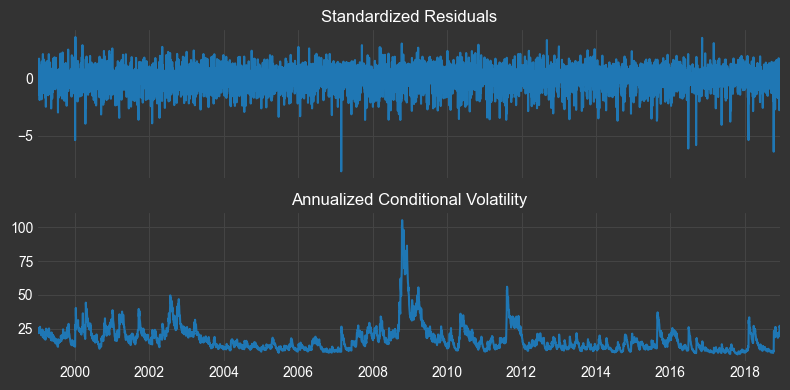

In [11]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [8, 4]
garchmod.plot(annualize="D")

sns.despine()
plt.tight_layout()

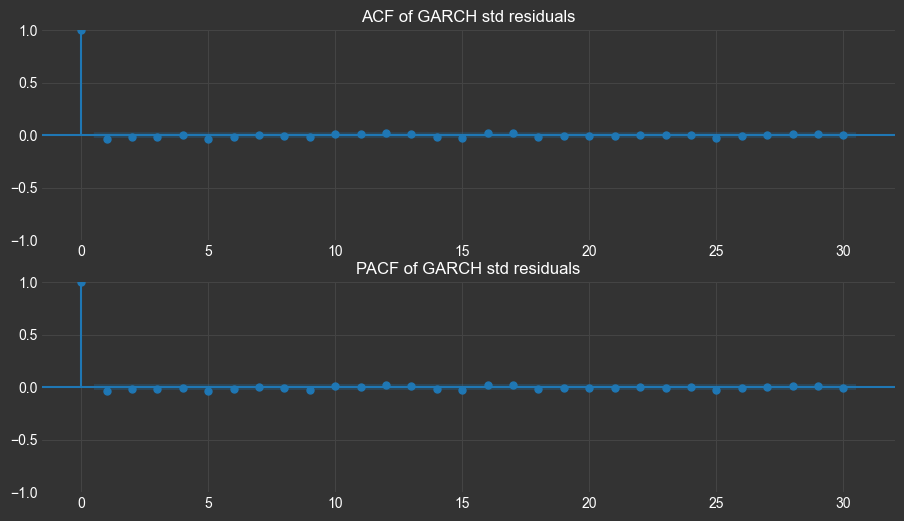

In [12]:
# Plot ACF and PACF of GARCH std residuals
fig, ax = plt.subplots(2, figsize=(11, 6))

plot_acf(garchmod.std_resid, ax=ax[0], lags=30, alpha=0.05, title="ACF of " + result_df.volatility_model[0] + " std residuals");

plot_pacf(garchmod.std_resid, ax=ax[1], lags=30, alpha=0.05, title="PACF of " + result_df.volatility_model[0] + " std residuals");

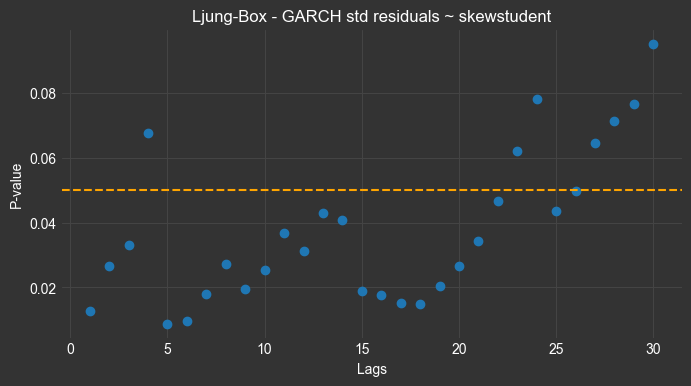

If any p-value < 0.05 there is autocorrelation.


In [13]:
# Ljung-Box test for GARCH residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(garchmod.std_resid, lags=30, return_df=True)
lb_pvalues = lb_test['lb_pvalue']

plt.plot(lb_pvalues, marker='o', linestyle='None')
plt.axhline(0.05, color='orange', linestyle='--') # label="Significance Threshold (0.05)"
plt.title("Ljung-Box - GARCH std residuals ~ " + result_df.distribution[0])
plt.xlabel("Lags")
plt.ylabel("P-value")
plt.legend()
plt.show()

print("If any p-value < 0.05 there is autocorrelation.")

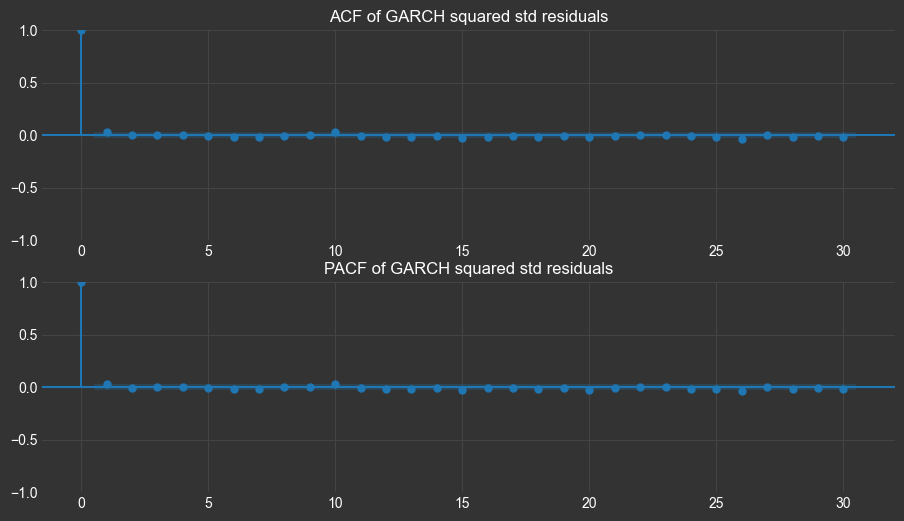

In [14]:
# Plot ACF-PACF of GARCH squared std residuals
fig, ax = plt.subplots(2, figsize=(11, 6))

plot_acf(garchmod.std_resid**2, ax=ax[0], lags=30, alpha=0.05, title="ACF of " + result_df.volatility_model[0] + " squared std residuals");

plot_pacf(garchmod.std_resid**2, ax=ax[1], lags=30, alpha=0.05, title="PACF of " + result_df.volatility_model[0] + " squared std residuals");

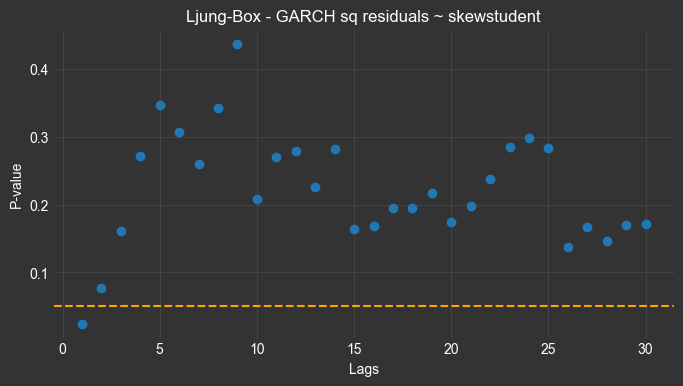

If any p-value < 0.05 there is autocorrelation.


In [15]:
# Ljung-Box for GARCH squared std residuals
lb_test = acorr_ljungbox(garchmod.std_resid**2, lags=30, return_df=True)
lb_pvalues = lb_test['lb_pvalue']

plt.plot(lb_pvalues, marker='o', linestyle='None') # label="Ljung-Box P-values"
plt.axhline(0.05, color='orange', linestyle='--') # label="Significance Threshold (0.05)"
plt.title("Ljung-Box - " + result_df.volatility_model[0] + " sq residuals ~ " + result_df.distribution[0]) # ~ iidN(0, 1)
plt.xlabel("Lags")
plt.ylabel("P-value")
plt.legend()
plt.show()

print("If any p-value < 0.05 there is autocorrelation.")

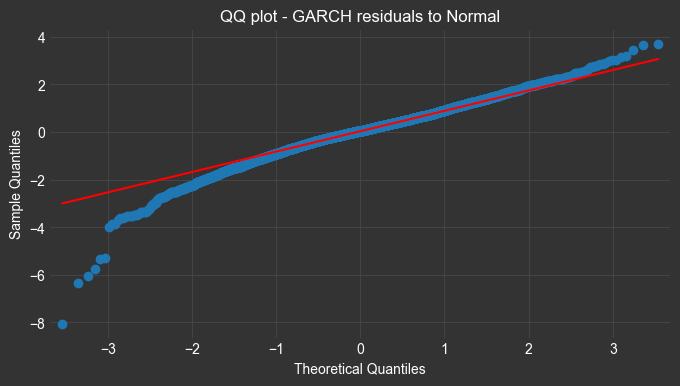

In [16]:
# QQ plot of GARCH std residuals
from statsmodels.graphics.api import qqplot
qqplot(garchmod.std_resid, line='q', fit=True)
plt.title("QQ plot - " + result_df.volatility_model[0] + " residuals to Normal")
plt.show()

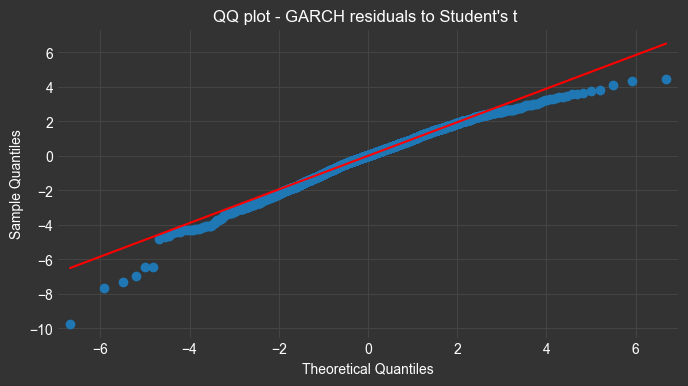

In [17]:
# QQ plot of GARCH std residuals
from statsmodels.graphics.api import qqplot
qqplot(garchmod.std_resid, dist=stats.t, line='q', fit=True)
plt.title("QQ plot - " + result_df.volatility_model[0] + " residuals to Student's t ")
plt.show()

## References

https://github.com/PacktPublishing/Python-for-Finance-Cookbook-2E

https://gist.github.com/hrishipoola/d96e4d6bc0b525231703541a49262216

https://github.com/marcopeix/TimeSeriesForecastingInPython

https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/tree/main

https://github.com/QuantLet/pyTSA/tree/main

https://github.com/PacktPublishing/Python-for-Finance-Second-Edition/tree/master